Extracted files: ['NH_ML_002_N_M_011_016.wav', 'NH_ML_002_N_F_006_002.wav', 'NH_ML_001_N_M_001_011.wav', 'H_ML_001_C_M_001_051.wav', 'NH_ML_001_N_M_001_027.wav']
Unique class labels: ['C' 'G' 'N' 'P' 'R']
Best Parameters: {'C': 0.1, 'max_iter': 50}
Train Accuracy: 0.9093
Test Accuracy: 0.6541


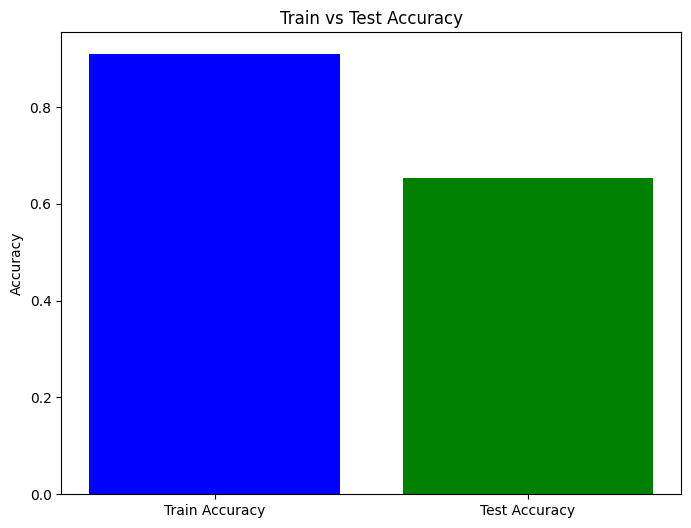

Classification Report:
              precision    recall  f1-score   support

           C       0.62      0.68      0.65        37
           G       0.56      0.42      0.48        12
           N       0.77      0.91      0.83        55
           P       0.45      0.33      0.38        15
           R       0.25      0.14      0.18        14

    accuracy                           0.65       133
   macro avg       0.53      0.50      0.51       133
weighted avg       0.62      0.65      0.63       133



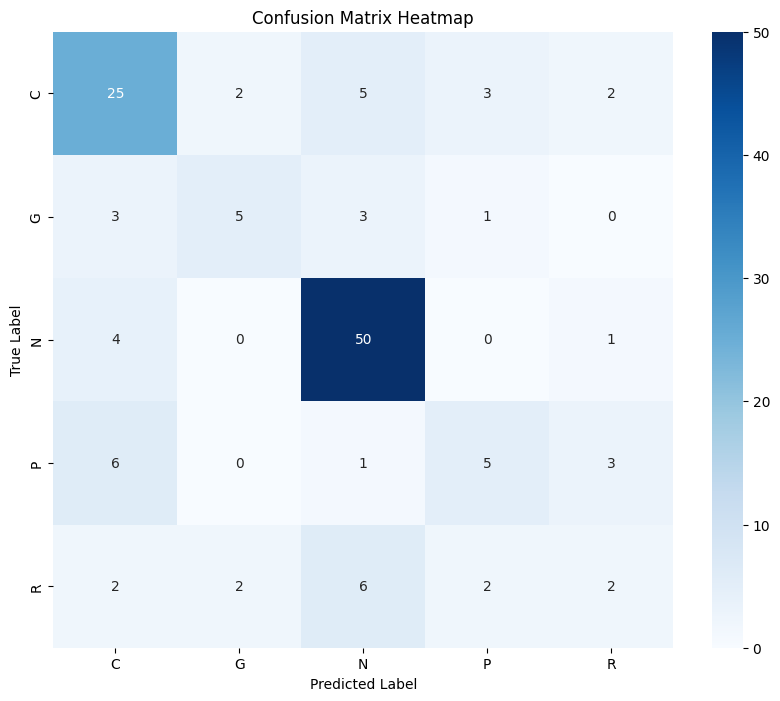

Macro F1-Score: 0.5051


In [4]:
import os
import librosa
import zipfile
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Step 1: Define the path to the zip file and extract it
zip_file_path = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4.zip'
extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Verify that the files have been extracted
extracted_files = os.listdir(extracted_folder)
print(f"Extracted files: {extracted_files[:5]}")  # Show first 5 files to confirm extraction

# Function to extract class from file name
def extract_class_from_file(file_name):
    parts = file_name.split('_')  # Split by underscores
    if len(parts) >= 4:
        class_label = parts[3]  # Extract the 4th part
        if class_label in ['G', 'P', 'R', 'C', 'N']:  # Add 'N' for non-hate categories
            return class_label
    return None  # Return None if the class cannot be determined

# Step 2: Extract features and labels from .wav files
labels = []
features = []
def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features (MFCC, Spectral Contrast, etc.)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Take the mean of the features over time
    mfcc_mean = np.mean(mfcc, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    mel_mean = np.mean(mel, axis=1)

    # Concatenate all features into a single vector
    features = np.hstack((mfcc_mean, chroma_mean, mel_mean))

    return features

for file_name in extracted_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(extracted_folder, file_name)
        class_label = extract_class_from_file(file_name)
        if class_label:  # Only process files with valid labels
            features.append(extract_features(file_path))
            labels.append(class_label)

# Convert features and labels to arrays
X = np.array(features)
y = np.array(labels)

# Check the unique labels
print(f"Unique class labels: {np.unique(y)}")

# Step 3: Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 4: Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [50, 100, 200]
}
pa_clf = PassiveAggressiveClassifier(random_state=42)
grid_search = GridSearchCV(pa_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_pa_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate on Test Data
y_train_pred = best_pa_model.predict(X_train)
y_test_pred = best_pa_model.predict(X_test)

# Decode labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Step 7: Metrics and Plots
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.title("Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_test_pred_decoded))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, y_test_pred_decoded, labels=label_encoder.classes_)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Macro F1-Score
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")


Extracted files: ['NH_ML_002_N_M_011_016.wav', 'NH_ML_002_N_F_006_002.wav', 'NH_ML_001_N_M_001_011.wav', 'H_ML_001_C_M_001_051.wav', 'NH_ML_001_N_M_001_027.wav']
Unique class labels: ['C' 'G' 'N' 'P' 'R']
Best Parameters: {'alpha': 10, 'solver': 'auto'}
Train Accuracy: 0.8601
Test Accuracy: 0.6692


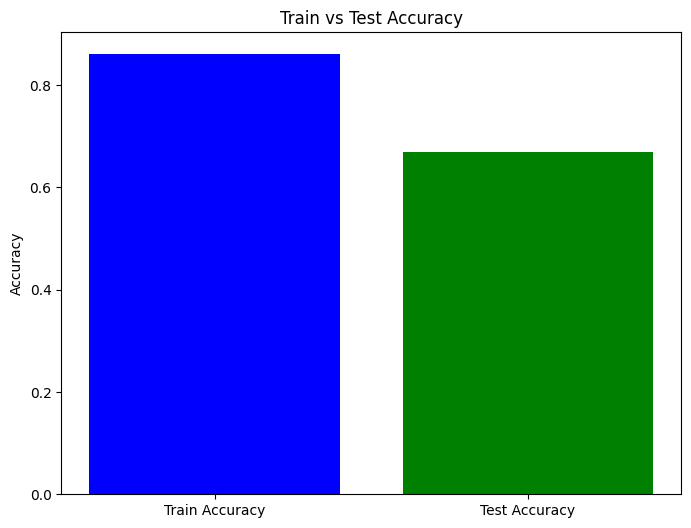

Classification Report:
              precision    recall  f1-score   support

           C       0.65      0.81      0.72        37
           G       0.40      0.17      0.24        12
           N       0.73      0.95      0.83        55
           P       0.60      0.20      0.30        15
           R       0.33      0.14      0.20        14

    accuracy                           0.67       133
   macro avg       0.54      0.45      0.46       133
weighted avg       0.62      0.67      0.62       133



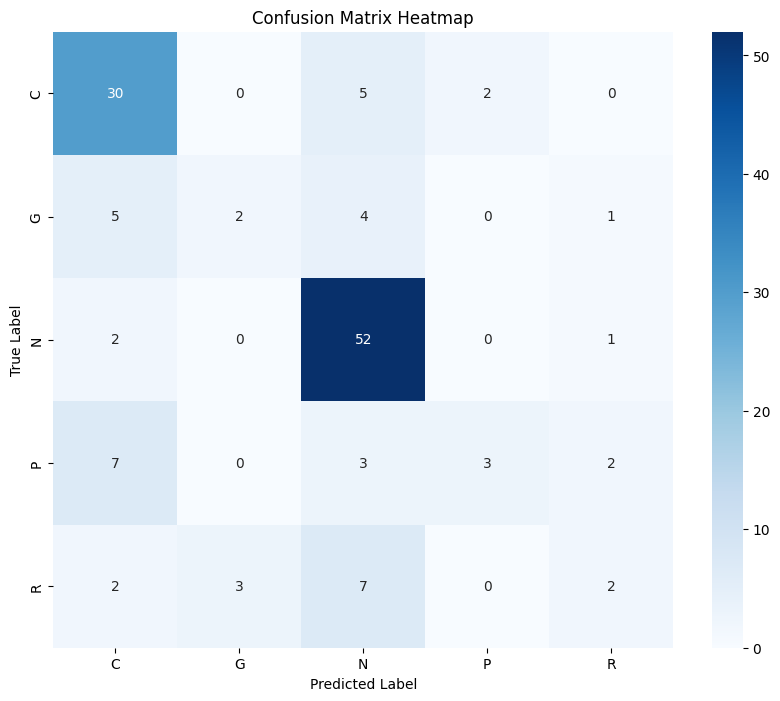

Macro F1-Score: 0.4567


In [5]:
import os
import librosa
import zipfile
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Step 1: Define the path to the zip file and extract it
zip_file_path = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4.zip'
extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Verify that the files have been extracted
extracted_files = os.listdir(extracted_folder)
print(f"Extracted files: {extracted_files[:5]}")  # Show first 5 files to confirm extraction

# Function to extract class from file name
def extract_class_from_file(file_name):
    parts = file_name.split('_')  # Split by underscores
    if len(parts) >= 4:
        class_label = parts[3]  # Extract the 4th part
        if class_label in ['G', 'P', 'R', 'C', 'N']:  # Add 'N' for non-hate categories
            return class_label
    return None  # Return None if the class cannot be determined

# Step 2: Extract features and labels from .wav files
labels = []
features = []

def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features (MFCC, Spectral Contrast, etc.)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Take the mean of the features over time
    mfcc_mean = np.mean(mfcc, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    mel_mean = np.mean(mel, axis=1)

    # Concatenate all features into a single vector
    features = np.hstack((mfcc_mean, chroma_mean, mel_mean))

    return features

# Extract features and labels from each file
for file_name in extracted_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(extracted_folder, file_name)
        class_label = extract_class_from_file(file_name)
        if class_label:  # Only process files with valid labels
            features.append(extract_features(file_path))
            labels.append(class_label)

# Convert features and labels to arrays
X = np.array(features)
y = np.array(labels)

# Check the unique labels
print(f"Unique class labels: {np.unique(y)}")

# Step 3: Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 4: Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Hyperparameter Tuning with GridSearchCV for RidgeClassifier
param_grid = {
    'alpha': [0.1, 1, 10],  # Regularization strength (alpha)
    'solver': ['auto', 'svd', 'lsqr', 'saga']  # Solvers available for RidgeClassifier
}
ridge_clf = RidgeClassifier()
grid_search = GridSearchCV(ridge_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_ridge_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 7: Evaluate on Test Data
y_train_pred = best_ridge_model.predict(X_train)
y_test_pred = best_ridge_model.predict(X_test)

# Decode labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Metrics and Plots
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.title("Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_test_pred_decoded))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, y_test_pred_decoded, labels=label_encoder.classes_)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Macro F1-Score
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")


Extracted files: ['NH_ML_002_N_M_011_016.wav', 'NH_ML_002_N_F_006_002.wav', 'NH_ML_001_N_M_001_011.wav', 'H_ML_001_C_M_001_051.wav', 'NH_ML_001_N_M_001_027.wav']
Unique class labels: ['C' 'G' 'N' 'P' 'R']
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train Accuracy: 1.0000
Test Accuracy: 0.7143


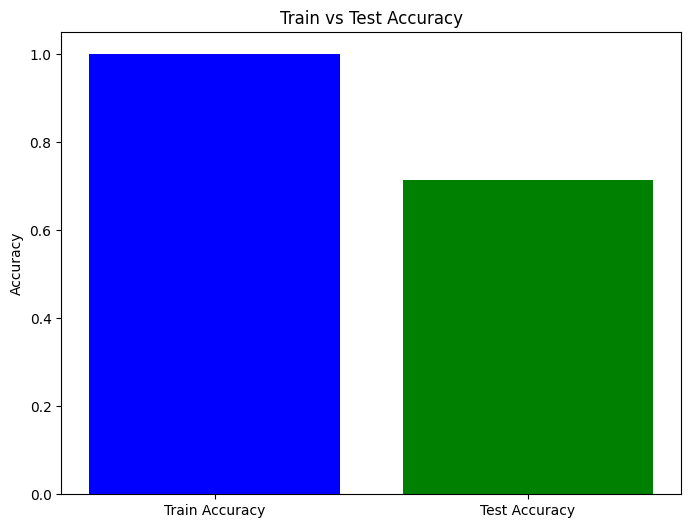

Classification Report:
              precision    recall  f1-score   support

           C       0.69      0.89      0.78        37
           G       1.00      0.17      0.29        12
           N       0.75      0.96      0.84        55
           P       0.64      0.47      0.54        15
           R       0.00      0.00      0.00        14

    accuracy                           0.71       133
   macro avg       0.61      0.50      0.49       133
weighted avg       0.66      0.71      0.65       133



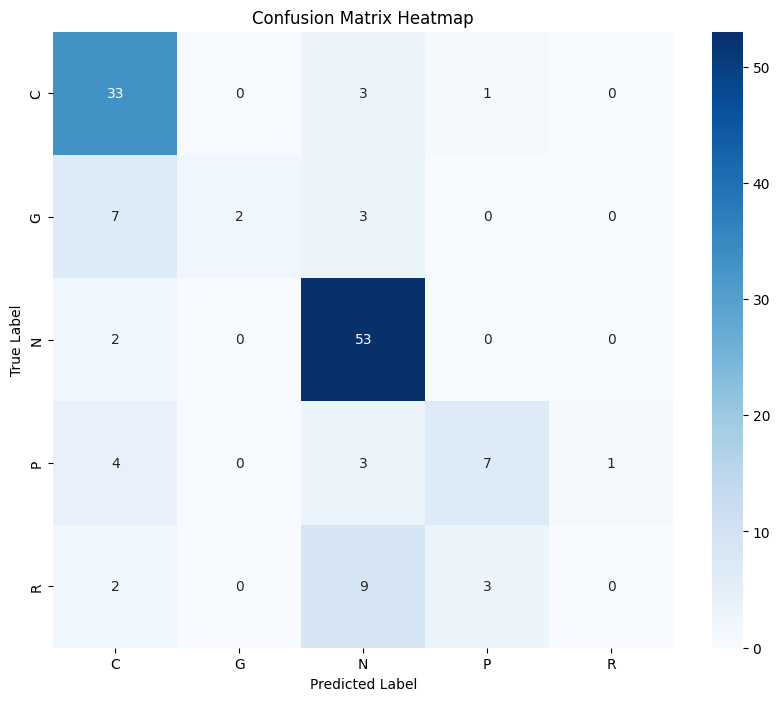

Macro F1-Score: 0.4884


In [6]:
import os
import librosa
import zipfile
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Step 1: Define the path to the zip file and extract it
zip_file_path = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4.zip'
extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Verify that the files have been extracted
extracted_files = os.listdir(extracted_folder)
print(f"Extracted files: {extracted_files[:5]}")  # Show first 5 files to confirm extraction

# Function to extract class from file name
def extract_class_from_file(file_name):
    parts = file_name.split('_')  # Split by underscores
    if len(parts) >= 4:
        class_label = parts[3]  # Extract the 4th part
        if class_label in ['G', 'P', 'R', 'C', 'N']:  # Add 'N' for non-hate categories
            return class_label
    return None  # Return None if the class cannot be determined

# Step 2: Extract features and labels from .wav files
labels = []
features = []

def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract features (MFCC, Spectral Contrast, etc.)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Take the mean of the features over time
    mfcc_mean = np.mean(mfcc, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    mel_mean = np.mean(mel, axis=1)

    # Concatenate all features into a single vector
    features = np.hstack((mfcc_mean, chroma_mean, mel_mean))

    return features

# Extract features and labels from each file
for file_name in extracted_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(extracted_folder, file_name)
        class_label = extract_class_from_file(file_name)
        if class_label:  # Only process files with valid labels
            features.append(extract_features(file_path))
            labels.append(class_label)

# Convert features and labels to arrays
X = np.array(features)
y = np.array(labels)

# Check the unique labels
print(f"Unique class labels: {np.unique(y)}")

# Step 3: Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 4: Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Hyperparameter Tuning with GridSearchCV for ExtraTreesClassifier
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}
extra_tree_clf = ExtraTreesClassifier(random_state=42)
grid_search = GridSearchCV(extra_tree_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_extra_tree_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 7: Evaluate on Test Data
y_train_pred = best_extra_tree_model.predict(X_train)
y_test_pred = best_extra_tree_model.predict(X_test)

# Decode labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Metrics and Plots
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'green'])
plt.title("Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_test_pred_decoded))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, y_test_pred_decoded, labels=label_encoder.classes_)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Macro F1-Score
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")


In [10]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import ExtraTreesClassifier
import zipfile

# Define the path to the test zip file and extracted folder
test_zip_file = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/finaled_test_audio_preprocessed4.zip'
test_extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/extracted_test_audio'

# Unzip Test Dataset
if not os.path.exists(test_extracted_folder):
    with zipfile.ZipFile(test_zip_file, 'r') as zip_ref:
        zip_ref.extractall(test_extracted_folder)

# Extract Test Features
def extract_class_from_file(file_name):
    parts = file_name.split('_')
    if len(parts) >= 4:
        class_label = parts[3]
        if class_label in ['G', 'P', 'R', 'C']:
            return class_label
    return None

def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract the features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCCs
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chromagram
    zcr = librosa.feature.zero_crossing_rate(y=y)  # Zero-Crossing Rate
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral Contrast

    # Aggregate features (mean over time for each)
    features = np.concatenate((
        np.mean(mfcc, axis=1),  # MFCC mean
        np.mean(chroma, axis=1),  # Chromagram mean
        np.mean(zcr, axis=1),  # Zero-crossing mean
        np.mean(spectral_contrast, axis=1)  # Spectral contrast mean
    ))

    # Make sure we always get 153 features
    expected_feature_size = 153
    if features.shape[0] < expected_feature_size:
        # If less, pad with zeros
        features = np.pad(features, (0, expected_feature_size - features.shape[0]), 'constant')
    elif features.shape[0] > expected_feature_size:
        # If more, truncate
        features = features[:expected_feature_size]

    return features

# Extract features for the test set (ensure this matches the training data)
test_files = os.listdir(test_extracted_folder)
test_features = []
test_labels = []

for file_name in test_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(test_extracted_folder, file_name)
        features = extract_features(file_path)
        test_features.append(features)

        class_label = extract_class_from_file(file_name)
        if class_label:
            test_labels.append(class_label)

# Convert Test Features to Array
X_test_final = np.array(test_features)

# Check the shape to ensure it matches (should be (50, 153) based on your dataset)
print(f"Test features shape: {X_test_final.shape}")

# Assuming the scaler was fit on training data, apply it to the test data
# You should have already fitted the scaler on the training data earlier, like this:
# scaler = StandardScaler().fit(X_train)
X_test_final = scaler.transform(X_test_final)

# Now use the trained models to predict on the test set
models = {
    "Passive Aggressive": best_pa_model,
    "Ridge": best_ridge_model,
    "ExtraTrees": best_extra_tree_model,
}

# Prepare an empty dictionary to hold the predictions
predictions_dict = {'File Name': test_files}

# For each model, predict and add the results to the dictionary
for model_name, model in models.items():
    test_predictions = model.predict(X_test_final)
    test_predictions_decoded = label_encoder.inverse_transform(test_predictions)

    # Get the first letter of each class label
    first_letter_predictions = [label[0] for label in test_predictions_decoded]

    predictions_dict[model_name] = first_letter_predictions

# Convert the dictionary to a DataFrame
test_predictions_df = pd.DataFrame(predictions_dict)

# Save Predictions to CSV
output_file = '/content/drive/MyDrive/drivetest_audio_predictions_basicml_models.csv'
test_predictions_df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


Test features shape: (50, 153)
Predictions saved to /content/drive/MyDrive/drivetest_audio_predictions_basicml_models.csv
